In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import scipy.stats as stats
import math
import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# train test split from sklearn
from sklearn.model_selection import train_test_split
# imputer from sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire 
import wrangle as w

a = .05

# Acquire

* I acquired this data from the Codeup database using mySQL workbench
* Each observation or row provides a value or description of a home
* Each column represents a feature of the property
* I acquired this data on Wednesday November 15th 

# Prepare

* Removed null values with query from mySQL and outlier parameters of property beds, baths and square footage and property value
* Split data into train, validate and test(approx. 50/30/20)
* Based on data from United States Census bureau limited home square footage to 2,500
* Converted fips numeric value to string value 
* Encoded Fips location strings into ones and zeros
* Renamed multiple columns : bedrooms, bathrooms, complete square footage 

 

## Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|Beds| Number of bedrooms in the home|
|Baths| Number of bathrooms in the home|
|sqft| The square footage of the home|
|room count| Represents the total number of rooms in the home|
|fips| The county the property is located in Los Angelese County CA, Ventura CA or Orange County CA|

In [2]:
#create, train, validate, test datasets

train, validate, test = w.wrangle_zillow()

In [3]:
# viewing size of train dataset
train.shape

(23377, 7)

In [6]:
#Brief view of data descriptive statistics 
train.describe()

,index,beds,baths,sqft,property_value,fips_Orange County CA,fips_Ventura County CA,rooms_count
count,23377.000000,23377.000000,23377.000000,23377.000000,2.337700e+04,23377.000000,23377.000000,23377.000000
mean,26048.392993,3.078239,1.967361,1537.146512,3.760634e+05,0.243872,0.079180,5.095179
std,15193.671017,0.797356,0.658768,446.231290,3.433157e+05,0.429426,0.270026,1.307805
min,5.000000,0.000000,0.000000,152.000000,3.254000e+03,0.000000,0.000000,0.000000
25%,12822.000000,3.000000,2.000000,1201.000000,1.600500e+05,0.000000,0.000000,4.000000
50%,25935.000000,3.000000,2.000000,1490.000000,3.162130e+05,0.000000,0.000000,5.000000
75%,39265.000000,4.000000,2.000000,1863.000000,4.944260e+05,0.000000,0.000000,6.000000
max,52441.000000,6.000000,5.000000,2500.000000,1.087391e+07,1.000000,1.000000,11.000000


# Exploration of Data

In [25]:
#Feature Engineering adding an additional column
train['rooms_count']= train['baths']+train['beds']

# reset index 
train=train.reset_index()

In [49]:
#Rounding up in rooms count 
train['rooms_count'] = train['rooms_count'].apply(np.ceil)

In [50]:
#Rounding up in rooms count 
train['baths'] = train['baths'].apply(np.ceil)

In [27]:
# most expensive property value 
train.property_value.max()

10873908.0

### What is the median and mean home price? 

In [28]:
#calculating median of property values 
median = train.property_value.median()
median

316213.0

In [29]:
#calculating mean of property values 
mean = train.property_value.mean()
mean

376063.3894426145

In [30]:
# difference between mean and median 
difference = mean - median

difference

59850.38944261451

<AxesSubplot:>

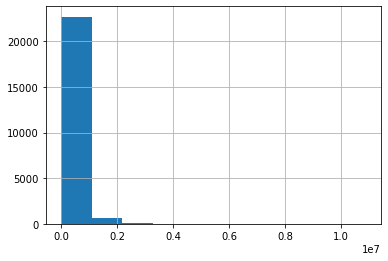

In [31]:
train.property_value.hist()

### Takeaways

- The median property value is 316,213
- The mean property value is 376,063
- The difference between these values is 59,850

# Statistical Questions Section

### Is there a significant difference in mean property value across Los Angeles, Ventura County and Orange County?  

In [33]:
# Count of properties in each County
train.fips.value_counts()

Los Angeles CA       15825
Orange County CA      5701
Ventura County CA     1851
Name: fips, dtype: int64

[Text(0.5, 1.0, 'Spread of Home Prices')]

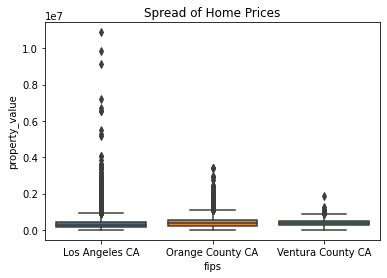

In [32]:
# box plot Fips vs Property value 
sns.boxplot(data=train, x='fips', y='property_value').set(title='Spread of Home Prices')


### Chart Takeaways 
- 5x as many homes in los angeles compared to Orange County in train sample
- 15x as many homes in Los Angeles compared to Ventura County
- Los Angeles has widest spread of property values due to it's outliers
- There appears to be a higher frequency of homes being sold in Los Angeles compared to the other counties


### Hypothesis

- Ho: There is no difference in mean property values across Los Angeles County, Ventura County and Orange County<br>
- Ha: There is a significant difference in mean property values across Los Angeles County, Ventura County and Orange County

In [38]:
# creating dataframes for each county and their property values
la = train[train.fips == 'Los Angeles CA'].property_value
oc = train[train.fips == 'Orange County CA'].property_value
vc = train[train.fips == 'Ventura County CA'].property_value

<AxesSubplot:>

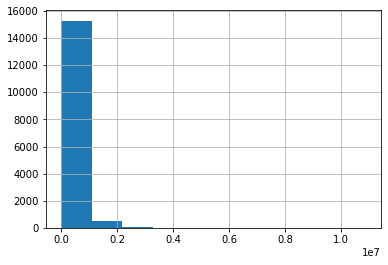

In [40]:
# histogram of home prices in La County
la.hist()

<AxesSubplot:>

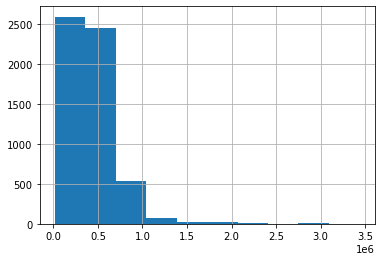

In [36]:
# histogram of home prices in Orange County
oc.hist()

<AxesSubplot:>

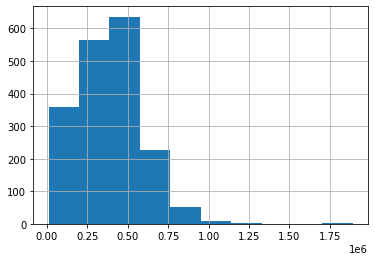

In [41]:
# histogram of home prices in Ventura County
vc.hist()

In [43]:
# variance of prices in La County
la.var()

137423766689.98007

In [44]:
# variance of prices in Orange County
oc.var()

85736846687.3435

In [45]:
# variance of prices in Ventura County
vc.var()

40991959968.33783

In [46]:
# results of statistical test 
stats.kruskal(la, oc, vc)

KruskalResult(statistic=601.2471343531851, pvalue=2.7595841708077645e-131)

### Takeaways 
- These prices are not normally distributed 
- Will use Kruskal-Wallis test since prices not normally distributed 
- Variances are not similar 
- There is a significant difference in the mean property value of the homes across Los Angeles, Ventura and Orange County 


### Is there a correlation between square footage and property value?  

[Text(0.5, 1.0, 'Sqft and Value')]

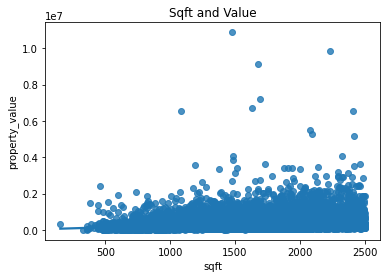

In [47]:
#visualization of sqft vs property value 

sns.regplot(x="sqft",
            y="property_value", 
            data=train).set(title='Sqft and Value')


### Chart Takeaways 
- As home square footage increases there are more outliers in property value

### Hypothesis: 

**Ho: There is no correlation between home square footage and property value.**<br>
**Ha: There is a correlation between home square footage and property value.** 

In [13]:
# statistics test results 
corr, p = stats.pearsonr(train.sqft, train.property_value)

corr, p

(0.2865340095600813, 0.0)

### Takeaways
- Test is significant and there is a weak positive correlation between home sqft and home price

### Is there a correlation between the bedrooms  and property value ?  

[Text(0.5, 1.0, 'Beds and Home Price')]

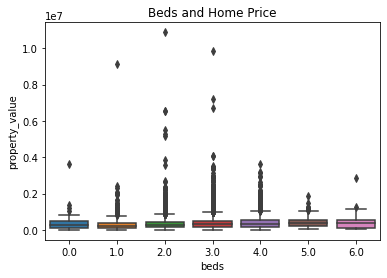

In [11]:
# box plot Bedrooms vs Property value 
sns.boxplot(data=train, x='beds', y='property_value').set(title='Beds and Home Price')


### Takeaways 

- Most outliers are seen between two and three bedroom homes 
- Across bedrooms there does not appear to be a major difference in their interquartile range

### Hypothesis: 

**Ho: There is no correlation between number of beds and property value.**<br>
**Ha: There is a correlation between number of beds and property value.** 


In [12]:
# Statistical test results 
corr, p = stats.pearsonr(train.beds, train.property_value)

corr, p

(0.0500699383280395, 1.86139227403694e-14)

### Takeaways 
- Bedrooms has a weak positive correlation to the property value 

### Is there a correlation between the bathrooms  and property value ?  

[Text(0.5, 1.0, 'Baths and Home Price')]

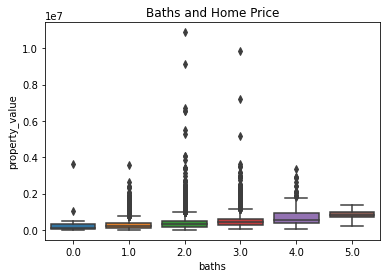

In [51]:
# box plot Bathrooms vs Property value 
sns.boxplot(data=train, x='baths', y='property_value').set(title='Baths and Home Price')

### Hypothesis: 

**Ho: There is no correlation between number of baths and property value.**<br>
**Ha: There is a correlation between number of baths and property value.** 


In [52]:
corr, p = stats.pearsonr(train.baths, train.property_value)

corr, p

(0.22904557158028294, 6.778922525436562e-276)

### Takeaways

- There is a weak positive correlation between bathrooms and property value
- There are slight differences in the interquartile ranges of the different bathroom counts

### Is there a correlation between the room count and property value ?  

[Text(0.5, 1.0, 'Rooms and Home Price')]

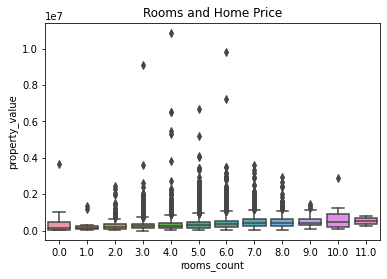

In [54]:
# box plot Bathrooms vs Property value 
sns.boxplot(data=train, x='rooms_count', y='property_value').set(title='Rooms and Home Price')

### Takeaways

- From 3 rooms to 6 rooms there is a wide range of price covered due to outliers 
- There is a consistent postive trend in max price as the room counts increase from 1 to 7

### Hypothesis

**Ho: There is no correlation between number of rooms and property value.**<br>
**Ha: There is a correlation between number of rooms and property value.** 

In [17]:
corr, p = stats.pearsonr(train.rooms_count, train.property_value)

corr, p

(0.15331077495661316, 6.365224724958109e-123)

### Takeaways
- there is a weak positive correlation between total rooms in a home and property value

## Exploration Summary

* Median price is x
* Mean property value is x
* The difference between Mean and Median is 147,254
* The features used for modeling will be baths, beds, sqft
* The statistical tests provide support that there is a correlation between Property value and baths, beds, sqft
* Statistical testing supports a significant relationship between fips code and property value 


## Features included in Models

* The features for my models are baths and sqft
* These features showed the strongest correlations with property value in my statistical tests 

## Features NOT included in Model

* Rooms count, bedrooms and fips will not be included in my Model
* The results of these statistical tests were significant but the strength was not as strong as the two variables I chose

## Setting up train, validate and test variables 

## Scale data for X train

In [55]:
# columns used as independent variables 
x_cols = ['baths','sqft']

In [56]:
# assigning features to x/y train, validate and test 
X_train = train[x_cols]
y_train = train['property_value']

X_validate = validate[x_cols]
y_validate = validate['property_value']

X_test = test[x_cols]
y_test = test['property_value']

In [57]:
# applying scaling to all the data splits.
scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(X_train)


# transforming train, validate and test datasets
X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)



# Modeling

### Introduction

* I will use Root Mean Squared error as my evaluation metric
* The median property value is 316,213
* The mean property value is 376,063
* My baseline model is created from the Root Mean Squared error (RMSE) of the median property value of the train and validate data set
* Models will be evaluated on train and validate data sets 
* The model that performs the best will be evaluated on the test data

## Baseline Model

In [72]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict property_value_pred_mean
prop_value_pred_mean = y_train['property_value'].mean()
y_train['prop_value_pred_mean'] = prop_value_pred_mean
y_validate['prop_value_pred_mean'] = prop_value_pred_mean

# 2. compute prop_value_pred_median
prop_value_pred_median = y_train['property_value'].median()
y_train['prop_value_pred_median'] = prop_value_pred_median
y_validate['prop_value_pred_median'] = prop_value_pred_median

# 3. RMSE of prop_value_pred_median
rmse_baseline_train = mean_squared_error(y_train.property_value, y_train.prop_value_pred_median)**(1/2)
rmse_baseline_validate = mean_squared_error(y_validate.property_value, y_validate.prop_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  348486.33 
Validate/Out-of-Sample:  322222.84


## LinearRegression OLS 

In [74]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_linearreg_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm)**(1/2)

# predict validate
y_validate['property_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_linearreg_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  348486.33078121033 
Validation/Out-of-Sample:  322222.84034009307


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [88]:
# Comparing performance to baseline 

print(((rmse_linearreg_train-rmse_train)/rmse_train)*100)


-5.6645672675766265


### Takeaways 
- model performs better than baseline 
- Reduces amount of explained error by almost 6% 

## LassoLars 

In [79]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_laso_lars_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lars)**(1/2)

# predict validate
y_validate['property_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_laso_lars_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  348486.33078121033 
Validation/Out-of-Sample:  322222.84034009307


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [89]:
print(((rmse_laso_lars_train-rmse_train)/rmse_train)*100)

-5.664555445376973


### Takeaways 
- model performs better than baseline 
- Reduces amount of explained error by almost 6% 

## TweedieRegressor(GLM) 

In [82]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.property_value)

# predict train
y_train['property_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_tweedie_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_glm)**(1/2)

# predict validate
y_validate['property_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_tweedie_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  348486.33078121033 
Validation/Out-of-Sample:  322222.84034009307


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/sta

In [90]:
print(((rmse_tweedie_train-rmse_train)/rmse_train)*100)

-1.4858363106280188


## Takeaways
- performs better than baseline 
- Reduces amount of explained error by 1.4%

## Polynomial regression - area, beds, baths

In [70]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
#X_test_degree2 = pf.transform(X_test)

## Linear Regression

In [93]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.property_value)

# predict train
y_train['property_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_linear_train = mean_squared_error(y_train.property_value, y_train.property_value_pred_lm2)**(1/2)

# predict validate
y_validate['property_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_linear_validate = mean_squared_error(y_validate.property_value, y_validate.property_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  348486.33078121033 
Validation/Out-of-Sample:  322222.84034009307


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [92]:
print(((rmse_linear_train-rmse_train)/rmse_train)*100)

-5.942727216995474


## Takeaways
- performs better than baseline 
- Reduces amount of explained error by almost 6%

## Best Model

### Linear Regression Model is best 

## Test Model
* I will run my Linear regression model on my test data

### Modeling Wrap 

* I would recommend this model for production because it does not over fit the data and it performs 4% better than the baseline

## Conclusion

### Summary
* The median property value is 316,213
* Statistical evidence supports correlations between property value and bedrooms, bathrooms and square feet of a home
* My model uses bathrooms and home square footage to determine home value
* There were very weak correlations between property value and bedrooms and total rooms in a home.  


### Modeling Summary 
* The final model performed approximately 6% better than the baseline
* I would recommend this model for production because it does not over fit the data and and performed better than baseline


### Recommendations
* Solicit for quantitative and qualitative data on why customer's select month to month contracts 
* Review incentives offered for each contract type

### Next Steps
* The next steps of this project would be to take more time to focus on statistically testing the features related to property location
* Review the data to determine if there are a similar amount of transactions across the three counties or if significantly more transactions occur in Los Angeles 